In [1]:
#Importing Libraries
from Plots import *
from Auxiliar_Functions import *
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
import time    
from IPython.display import HTML

## Table of Contents:
* [1.EDOs](#first-bullet)
* [2.Results](#second-bullet)
    * [2.1 - Comparing Energies and M.O.](#2.1-bullet)
    * [2.2 - Comparing Angular Cases](#2.2-bullet)
    * [2.3 - Without Slow ($\omega= 0$)](#2.3-bullet)
* [3.Comparing Numerical Solvers](#3-bullet)
    * [3.1 - With Slow ($\omega \neq 0$)](#3.1-bullet)
    * [3.2 - Without Slow ($\omega= 0$)](#3.2-bullet)
    * [3.3 - Using *DifferentialEquations.jl*](#3.3-bullet)
    * [3.4 - Ian's Paper](#3.4-bullet)
* [4.Fourier Analysis](#4-bullet)
* [5.Comparing Fast and Slow](#5-bullet)
* [Draft](#draft-bullet)

# Angular Distribution

In [8]:
def angular_dist_Ian(theta,a,b):
    return 0.45 - a +(0.1/b)*np.exp(-1*(1-np.cos(theta))**2/(2*b**2))

def theta_dist(theta,nu_type,case):
    if nu_type=="nu_x" or nu_type=="nu_x_bar":
        return np.where(theta<-100,0.0,0.0)
    
    # New Developments in Flavor Evolution of a Dense Neutrino Gas - Irene Tamborra, Shashank Shalgar
    #https://arxiv.org/abs/2011.01948
    if case==1:
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nu_e_bar":
            return np.where(theta<math.pi/3,1,0.25)
    elif case==2:
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nu_e_bar":
            return np.where(theta<math.pi/4,1,0.5)
    elif case==3:
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nu_e_bar":
            return np.where(theta<math.pi/3,0.5*1.5,0.5)
        
    #Neutrino Flavor Pendulum Reloaded: The Case of Fast Pairwise Conversion - Padilla-Gay, Irene Tamborra, Georg G. Raffelt 
    # https://arxiv.org/abs/2109.14627
    elif case=='A':
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nu_e_bar":
            return angular_dist_Ian(theta,0,0.4)
    elif case=='B':
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nu_e_bar":
            return angular_dist_Ian(theta,0.02,0.4)       
    elif case=='C':
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nu_e_bar":
            return angular_dist_Ian(theta,0.02,0.6)
    elif case=='D':
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nu_e_bar":
            return angular_dist_Ian(theta,0.06,0.2)
    
    else:
        print("Not a valid angular distribution!")


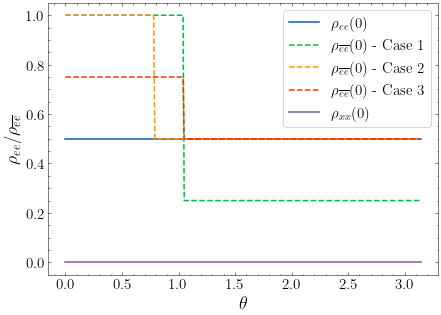

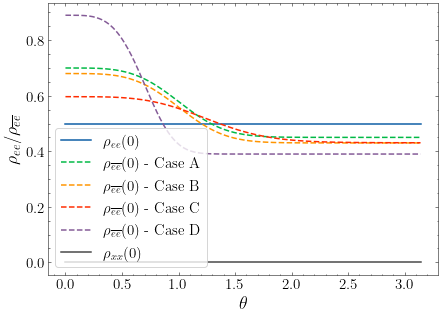

In [9]:
theta_vec=np.arange(0,math.pi,0.01)
plt.figure(figsize=(7,5))
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e",1),label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e_bar",1),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case 1")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e_bar",2),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case 2")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e_bar",3),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case 3")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_x",1),label=r"$\rho_{xx}(0)$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\rho_{ee}$/$\rho_{\overline{ee}}$")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e",'A'),label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e_bar",'A'),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case A")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e_bar",'B'),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case B")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e_bar",'C'),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case C")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e_bar",'D'),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case D")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_x",'A'),label=r"$\rho_{xx}(0)$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\rho_{ee}$/$\rho_{\overline{ee}}$")
plt.legend()
plt.show()

# 1. EDOs <a class="anchor" id="first-bullet"></a>

In [10]:
def initiate_v2(nu_types,t_i,t_f,E_nu,delta_m2,mu_0,theta_bins,case):
    y0=[] #Initial state
    flavor_sign=[1,-1]
    omega=delta_m2/(2*E_nu*10**6) #eV 
    rho_ex=0
    if delta_m2==0:
        rho_ex=10**-7

    cos_theta_vec=np.linspace(-1,1,theta_bins)
    cos_theta_step=cos_theta_vec[1]-cos_theta_vec[0]
    n_theta=len(cos_theta_vec)
    n_f=len(nu_types)
    n_dim=(n_f**2)-1
    n_antipart=2

    index_order=[n_theta,n_f,n_dim,n_antipart]
    
    for i in range(n_theta):        
      for j in range(n_f):
        #nu
        nu_spec=theta_dist(np.arccos(cos_theta_vec[i]),nu_types[j],case)*cos_theta_step
        y0.append(rho_ex)
        y0.append(rho_ex)
        y0.append(flavor_sign[j]*nu_spec)
        #nubar
        nu_spec=theta_dist(np.arccos(cos_theta_vec[i]),nu_types[j]+'_bar',case)*cos_theta_step
        y0.append(rho_ex)
        y0.append(rho_ex)
        y0.append(flavor_sign[j]*nu_spec)

    #t array
    t_i = t_i*c_const*from_eV_to_1_over_m #from s to eV⁻¹
    t_f = t_f*c_const*from_eV_to_1_over_m #from s to eV⁻¹
    t_step=(2*np.pi/max(omega,mu_0))/30
    t = np.arange(t_i,t_f,t_step) #eV⁻¹

    return y0,omega,E_nu,t,mu_0,n_f,n_dim,n_theta,cos_theta_vec

In [11]:
def from_1D_to_MultiD(y,n_f,n_dim,n_theta):
    nu, nubar = [],[]    
    #Filling [Theta bin][Nu_Flavors][3components]    
    for i in range(n_theta):
      nu.append([])
      nubar.append([])
      for j in range(n_f):
        nu[i].append([])
        nubar[i].append([])
        for k in range(n_dim):
          #nu 
          nu_index=(i*2*n_dim*n_f)+(j*2*n_dim)+k
          nu[i][j].append(y[nu_index])
          #nubar   
          nubar_index=(i*2*n_dim*n_f)+(j*2*n_dim)+(k+n_dim)
          nubar[i][j].append(y[nubar_index])
    return nu, nubar 

In [12]:
def func_Collective_nu_v2(y, time, params):
    omega,E,theta_V,mu_0,n_f,n_dim,n_theta,cos_theta_vec= params  # unpack parameters
    
    B=np.array(B_vec(n_dim,theta_V))
    L=np.array(L_vec(n_dim))
    mu=mu_0
    lamb=lambda_supernova(time,"no",0)

    derivs=[]
    nu, nubar = from_1D_to_MultiD(y,n_f,n_dim,n_theta)
    
    #Summed nu and nubar components
    nu_sum, nubar_sum=[],[]
    nu_sum_theta, nubar_sum_theta=[],[]
    nu_aux=np.transpose(nu,(2,0,1))
    nubar_aux=np.transpose(nubar,(2,0,1))

    for i in range(n_dim):
      nu_sum.append(sum(map(sum,nu_aux[i])))
      nubar_sum.append(sum(map(sum,nubar_aux[i])))
      nu_sum_theta.append(sum(cos_theta_vec*list(map(sum,nu_aux[i]))))
      nubar_sum_theta.append(sum(cos_theta_vec*list(map(sum,nubar_aux[i]))))
    
    nu_sum=np.array(nu_sum)
    nubar_sum=np.array(nubar_sum)
    nu_sum_theta=np.array(nu_sum_theta)
    nubar_sum_theta=np.array(nubar_sum_theta)
    
    # list of dy/dt=f functions
    for i in range(n_theta):
      for j in range(n_f):
        #nu
        aux=B*omega+L*lamb-mu*((nu_sum-nubar_sum)-cos_theta_vec[i]*(nu_sum_theta-nubar_sum_theta))
        P_aux= cross_prod(nu[i][j],aux)
        for k in range(n_dim):
          derivs.append(P_aux[k])
        
        #nubar
        aux=-1*B*omega+L*lamb-mu*((nu_sum-nubar_sum)-cos_theta_vec[i]*(nu_sum_theta-nubar_sum_theta))
        P_aux= cross_prod(nubar[i][j],aux)
        for k in range(n_dim):
          derivs.append(P_aux[k])

    return derivs

def func_Collective_nu_v3(time,y, params):
    omega,E,theta_V,mu_0,n_f,n_dim,n_theta,cos_theta_vec= params  # unpack parameters
    B=np.array(B_vec(n_dim,theta_V))
    L=np.array(L_vec(n_dim))
    mu=mu_0
    lamb=lambda_supernova(time,"no",0)

    derivs=[]
    nu, nubar = from_1D_to_MultiD(y,n_f,n_dim,n_theta)
    
    #Summed nu and nubar components
    nu_sum, nubar_sum=[],[]
    nu_sum_theta, nubar_sum_theta=[],[]
    nu_aux=np.transpose(nu,(2,0,1))
    nubar_aux=np.transpose(nubar,(2,0,1))

    for i in range(n_dim):
      nu_sum.append(sum(map(sum,nu_aux[i])))
      nubar_sum.append(sum(map(sum,nubar_aux[i])))
      nu_sum_theta.append(sum(cos_theta_vec*list(map(sum,nu_aux[i]))))
      nubar_sum_theta.append(sum(cos_theta_vec*list(map(sum,nubar_aux[i]))))
    
    nu_sum=np.array(nu_sum)
    nubar_sum=np.array(nubar_sum)
    nu_sum_theta=np.array(nu_sum_theta)
    nubar_sum_theta=np.array(nubar_sum_theta)
    
    # list of dy/dt=f functions
    for i in range(n_theta):
      for j in range(n_f):
        #nu
        aux=B*omega+L*lamb-mu*((nu_sum-nubar_sum)-cos_theta_vec[i]*(nu_sum_theta-nubar_sum_theta))
        P_aux= cross_prod(nu[i][j],aux)
        for k in range(n_dim):
          derivs.append(P_aux[k])
        
        #nubar
        aux=-1*B*omega+L*lamb-mu*((nu_sum-nubar_sum)-cos_theta_vec[i]*(nu_sum_theta-nubar_sum_theta))
        P_aux= cross_prod(nubar[i][j],aux)
        for k in range(n_dim):
          derivs.append(P_aux[k])

    return derivs

In [13]:
def solver_two_families_v2(nu_types,t_i,t_f,E_nu,delta_m2,theta_V,mu_0,theta_bins,case,mass_ord):
    y0,omega,E,t,mu_0,n_f,n_dim,n_theta,cos_theta_vec=initiate_v2(nu_types,t_i,t_f,E_nu,delta_m2,mu_0,theta_bins,case)
    
    if mass_ord=="NH": 
        params=omega,E,theta_V,mu_0,n_f,n_dim,n_theta,np.array(cos_theta_vec)
    elif mass_ord=="IH":
        params=-1*omega,E,theta_V,mu_0,n_f,n_dim,n_theta,np.array(cos_theta_vec)
    else:
        print("Not a mass ordering option!")
    psoln= odeint(func_Collective_nu_v2, y0, t, args=(params,))

    nu, nubar= read_output(psoln,(n_f,n_dim,n_theta))    
    t=t/(c_const*from_eV_to_1_over_m) #From eV⁻¹ to km

    return cos_theta_vec,t,mu_0, nu, nubar

def solver_two_families_v3(nu_types,t_i,t_f,E_nu,delta_m2,theta_V,mu_0,theta_bins,case,mass_ord,solver):
    y0,omega,E,t,mu_0,n_f,n_dim,n_theta,cos_theta_vec=initiate_v2(nu_types,t_i,t_f,E_nu,delta_m2,mu_0,theta_bins,case)
    
    if mass_ord=="NH": 
        params=omega,E,theta_V,mu_0,n_f,n_dim,n_theta,np.array(cos_theta_vec)
    elif mass_ord=="IH":
        params=-1*omega,E,theta_V,mu_0,n_f,n_dim,n_theta,np.array(cos_theta_vec)
    else:
        print("Not a mass ordering option!")
    if solver=="odeint":
        y_sol= odeint(func_Collective_nu_v2, y0, t, args=(params,),atol=1e-9)
    else:
        psoln= solve_ivp(func_Collective_nu_v3,t_span=[t[0],t[-1]] ,y0=y0, method=solver, args=(params,),t_eval=t,atol=1e-9)
        y_sol=np.transpose(psoln.y)
        t=psoln.t
    nu, nubar= read_output(y_sol,(n_f,n_dim,n_theta))    
    t=t/(c_const*from_eV_to_1_over_m) #From eV⁻¹ to km

    return cos_theta_vec,t,mu_0, nu, nubar

# 3.Comparing Numerical Solvers <a class="anchor" id="3-bullet"></a>

# 3.2 - Without Slow ($\omega= 0$) <a class="anchor" id="3.2-bullet"></a>

In [14]:
#Neutrino Mixing
theta_V=10**-6 #rad
nu_types=['nu_e','nu_x']

#Neutrino Scenario
scenarios=[["NH",1,10,"RK45",0],["NH",1,10,"DOP853",0],["NH",1,10,"odeint",0],["NH",1,10,"Radau",0],["NH",1,10,"BDF",0]]
# scenarios=[["NH",1,10,"RK45",0],["NH",1,10,"DOP853",0],["NH",1,10,"odeint",0]]
mu_0=10**3 #km⁻¹
mu_0=mu_0/from_eV_to_1_over_km #eV

#Numerical Solver Info
t_i,t_f=0,10*10**(-6) #s
theta_bins=100
theta_step=np.pi/theta_bins
cos_theta_step=2/theta_bins

In [15]:
nu,nubar=[],[]
t_vec=[]
for mass_ord,case,E_nu,solver,delta_m2 in scenarios:
    start_time = time.time()
    theta_vec,t,mu_0, nu_aux, nubar_aux= solver_two_families_v3(nu_types,t_i,t_f,E_nu,delta_m2,theta_V,mu_0,theta_bins,case,mass_ord,solver)
    print(solver," took %s minutes" % ((time.time() - start_time)/60))
    nu.append(nu_aux)
    nubar.append(nubar_aux)
    t_vec.append(t)

RK45  took 1.0980463822682698 minutes
DOP853  took 1.0429910143216452 minutes
odeint  took 1.2420770883560182 minutes
Radau  took 15.085207947095235 minutes
BDF  took 5.408709116776785 minutes


In [16]:
rho_ex_theta_time=[]
rho_ex_mean_time=[]
P_ex_theta_time=[]
P_ex_mean_time=[]
for i in range(len(scenarios)):
    rho_ex_theta_time_aux= 1/2*np.sqrt(np.transpose(nu[i][0][0])**2+np.transpose(nu[i][1][0])**2)
    rho_ex_theta_time.append(rho_ex_theta_time_aux)
    rho_ex_mean_time.append(sum(rho_ex_theta_time_aux)*cos_theta_step/2)
    
    P_ex_theta_time_aux=[]
    for j in range(theta_bins):
        P_ex_theta_time_aux.append(1/2*(1-np.transpose(nu[i][2][0])[j]/nu[i][2][0][0][j]))
    P_ex_theta_time.append(P_ex_theta_time_aux)
    P_ex_mean_time.append(sum(P_ex_theta_time_aux)*cos_theta_step/2)

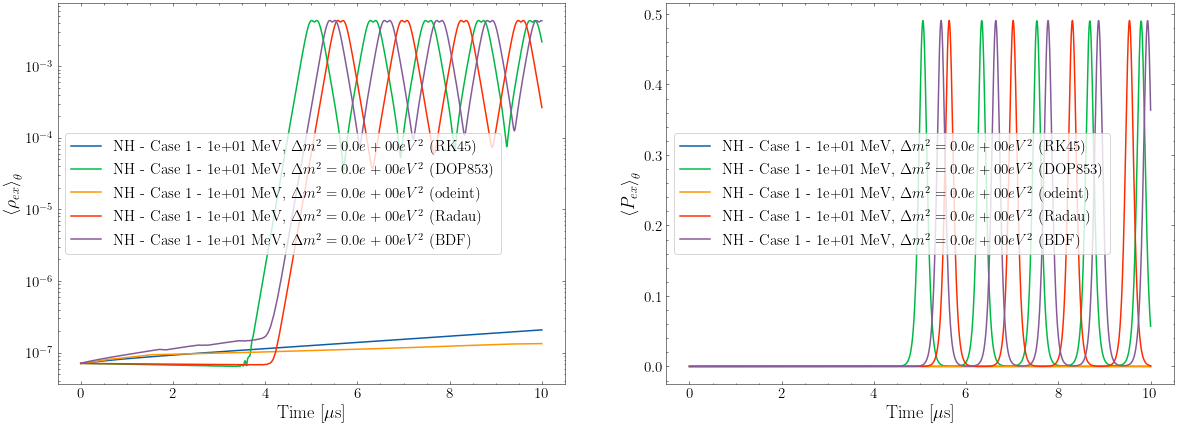

In [17]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
for i in range(len(scenarios)):
    plt.plot((10**6)*t_vec[i],rho_ex_mean_time[i],label="%s - Case %d - %.0e MeV, $\Delta m^2=%.1e eV^2$ (%s)"%(scenarios[i][0],scenarios[i][1],scenarios[i][2],scenarios[i][4],scenarios[i][3]))
plt.xlabel("Time [$\mu$s]")
plt.ylabel(r"$\left \langle  \rho_{ex} \right \rangle_{\theta}$")
plt.legend()
# plt.ylim(7.0710678e-8,7.07106785e-8)
# plt.xlim(0,0.01)
plt.yscale('log')

plt.subplot(1,2,2)
for i in range(len(scenarios)):
    plt.plot((10**6)*t_vec[i],P_ex_mean_time[i],label="%s - Case %d - %.0e MeV, $\Delta m^2=%.1e eV^2$ (%s)"%(scenarios[i][0],scenarios[i][1],scenarios[i][2],scenarios[i][4],scenarios[i][3]))
plt.xlabel("Time [$\mu$s]")
plt.ylabel(r"$\left \langle  P_{ex} \right \rangle_{\theta}$")
plt.legend()

# 3.3 - Using *DifferentialEquations.jl* <a class="anchor" id="3.3-bullet"></a>

In [1]:
from diffeqpy import de

OSError: dlopen(/Applications/Julia-1.8.app/Contents/Resources/julia/lib/libjulia.1.8.dylib, 0x000A): tried: '/Applications/Julia-1.8.app/Contents/Resources/julia/lib/libjulia.1.8.dylib' (mach-o file, but is an incompatible architecture (have (arm64), need (x86_64)))